# Case 2 - Myocardial Infection

### David's file

In [1]:
import os
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import gower
import random
from time import time
from collections import defaultdict
sns.set_theme()
import pandas as pd
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from prince.prince import MCA

Link to data: https://archive.ics.uci.edu/ml/datasets/Myocardial+infarction+complications#

## Data Load and pre-processing

In [2]:
def detect_variable_type(df,Max_Number_Of_Ordinal_Values=10,verbose=True):
    # classification of variables into continuous, binary, ordinal
    # let us assume for the moment that all categorical variables have been converted to the (transformed?) complete disjunctive table
    # hence they will be represented as sets of binary variables
    
    binary = []
    continuous = []
    ordinal = []
    variable_types = []

    for col in df.columns[1:]: 
        vals = np.sort(df[col].unique())
        #print(col,vals)
        vals = [x for x in vals if str(x) != 'nan']
        tp = 'UNKNOWN'
        # NaNs must be 
        if len(vals)==2 or len(vals)==1:
            tp = 'BINARY'
            binary.append(col)
        if len(vals)>Max_Number_Of_Ordinal_Values:
            tp = 'CONTINUOUS'
            continuous.append(col)
        if len(vals)>2 and len(vals)<=Max_Number_Of_Ordinal_Values:
            tp = 'ORDINAL'
            ordinal.append(col)
        variable_types.append(tp)
        if len(vals)>Max_Number_Of_Ordinal_Values:
            if verbose:
                print(col,'\t','\t[',np.min(vals),'... ',len(vals),'values...',np.max(vals),']\t',tp)
        else:
            if verbose:
                print(col,'\t',vals,'\t',len(vals),'\t',tp)
    return variable_types, binary, continuous, ordinal

In [3]:
D = pd.read_csv('Myocardial infarction complications Database.csv', na_values ='?')

### Check NaNs

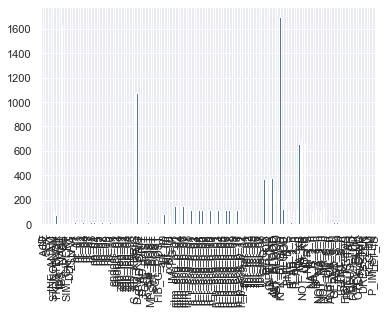

In [4]:
D.isna().sum(axis=0).plot.bar()

Many NaNs. Consider removing the two variables with majority of NaNs and impute the rest using KNN (or simply median/**mode**)

In [5]:
nan_idx = D.isna().sum(axis=0) > 200

In [6]:
c = D.columns[nan_idx]

In [7]:
df = D.drop(c, axis=1)
df = df.drop("ID", axis=1)
age_median = df["AGE"].median()
df["AGE_HIGH"] = (df["AGE"] >= age_median).astype(int)
df["AGE_LOW"] = (df["AGE"] < age_median).astype(int)
df = df.drop("AGE", axis=1)

In [8]:
variable_types, binary, continuous, ordinal = detect_variable_type(df, verbose=False, Max_Number_Of_Ordinal_Values=25)

In [9]:
def binarize_df(df, variable_type):
    df_copy = df.copy()
    df_cols = df.columns
    
    for i, var_type in enumerate(variable_type):
        col_name = df_cols[i]
        if var_type == "ORDINAL":
            df_copy[col_name].fillna(df_copy[col_name].mode()[0], inplace=True)
            one_hot = pd.get_dummies(df_copy[col_name], prefix=col_name)
            df_copy = df_copy.drop(col_name, axis = 1)
            df_copy = df_copy.join(one_hot)
        elif var_type == "BINARY":
            df_copy[col_name].fillna(df_copy[col_name].mode()[0], inplace=True)
            if len(np.unique(df_copy[col_name])) > 2:
                one_hot = pd.get_dummies(df_copy[col_name], prefix=col_name)
                df_copy = df_copy.drop(col_name, axis = 1)
                df_copy = df_copy.join(one_hot)           
            
        elif var_type == "CONTINOUS":
            median_cont = df_copy[col_name].median()
            df_copy[col_name].fillna(median_cont, inplace=True)
            df_copy[col_name + "_HIGH"] = (df_copy[col_name] >= median_cont).astype(int)
            df_copy[col_name + "_LOW"] = (df_copy[col_name] < median_cont).astype(int)
            
    
    return df_copy

In [10]:
df_copy = binarize_df(df, variable_types)

In [109]:
from scipy.sparse import csr_matrix
from scipy.special import logsumexp

In [127]:
mca = MCA(n_components=2)

In [11]:
df_copy_drop = df_copy.dropna(axis=0)
is_NaN = df_copy.isnull()
row_has_NaN = is_NaN.any(axis=1)==False

In [148]:
mca.fit(df_copy_drop)

MCA()

In [149]:
mca.total_inertia_ = 1

In [25]:
y = df["LET_IS"]
y.loc[row_has_NaN]

0       0
1       0
2       0
3       0
4       0
       ..
1695    3
1696    1
1697    6
1698    1
1699    1
Name: LET_IS, Length: 1690, dtype: int64

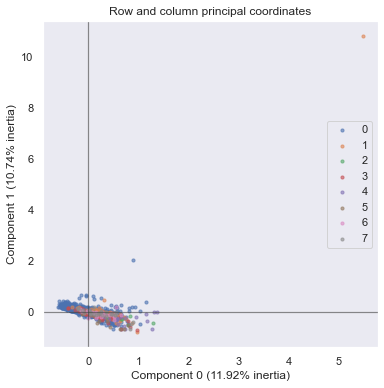

In [153]:
mca.plot_coordinates(df_copy_drop, row_groups=list(y.loc[row_has_NaN]), show_column_points=False)

In [15]:
dist_matrix = gower.gower_matrix(X)

# COSINE DIST

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
df_copy_drop = df_copy.dropna(axis=0)
is_NaN = df_copy.isnull()
row_has_NaN = is_NaN.any(axis=1)==False

In [13]:
cosine_sim_mat = 1 - cosine_similarity(df_copy_drop.values)
cosine_sim_mat[np.diag_indices_from(cosine_sim_mat)] = 0
#cosine_sim_mat = np.fill_diagonal(cosine_sim_mat, 0)
condensed_dist_mat_cosine = squareform(cosine_sim_mat)

In [14]:
Z = linkage(condensed_dist_mat_cosine, method="ward")

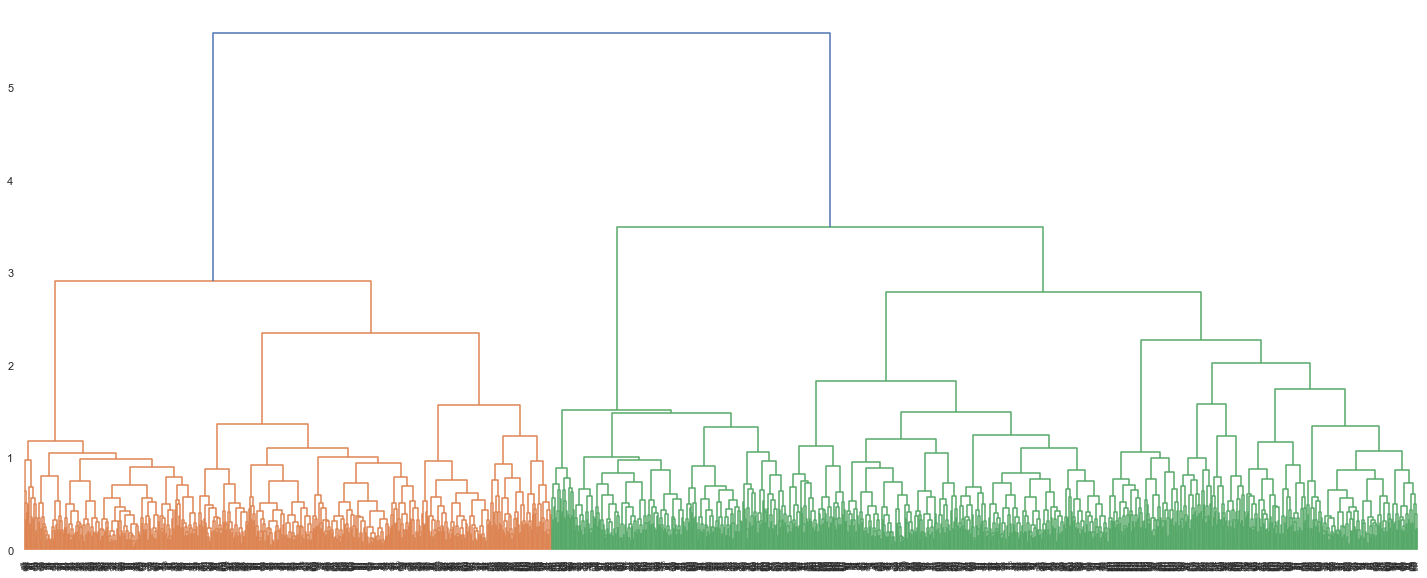

In [83]:
fig, ax = plt.subplots(figsize=(25, 10))
dn = dendrogram(Z, ax=ax, leaf_rotation=90)

## CLUSTERS AS INPUT TO CLASSIFIER

In [15]:
from sklearn.cluster import OPTICS
clf = OPTICS(min_samples=5)

In [16]:
clf.fit(cosine_sim_mat)

OPTICS()

(array([1650.,    7.,    0.,    7.,    0.,    7.,    5.,    0.,    9.,
           5.]),
 array([-1. , -0.4,  0.2,  0.8,  1.4,  2. ,  2.6,  3.2,  3.8,  4.4,  5. ]),
 <a list of 10 Patch objects>)

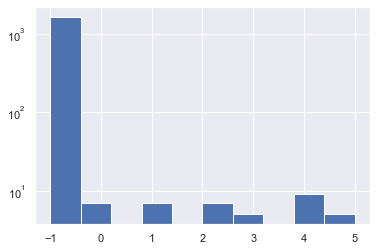

In [17]:
plt.hist(clf.labels_, log=True)

In [18]:
np.unique(clf.labels_)


array([-1,  0,  1,  2,  3,  4,  5])

In [20]:
labels = clf.labels_ + 1

In [100]:
## NAIVE BAYES
from sklearn.naive_bayes import CategoricalNB, BernoulliNB
from sklearn.model_selection import cross_val_score
y = df["LET_IS"]
y_non_nan = y.loc[row_has_NaN]
df_copy_drop["NB"] = labels

<ipython-input-100-86a79e715a14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_drop["NB"] = labels


In [101]:
# WITH CLUSTER FEATURE
clf = BernoulliNB(alpha=0.05, binarize=None, fit_prior=False)
cross_val = cross_val_score(clf, df_copy_drop.values, y_non_nan, cv = 10)
print('Test accuracy: ', np.mean(cross_val), '\nTest accuracy for each fold', cross_val)

Test accuracy:  0.985207100591716 
Test accuracy for each fold [0.99408284 1.         1.         0.96449704 0.95857988 0.98224852
 1.         0.99408284 0.99408284 0.96449704]


In [110]:
# WITHOUT CLUSTER FEATURE
clf = BernoulliNB(alpha=0.01, binarize=None)
cross_val = cross_val_score(clf, df_copy_drop.drop("NB", axis=1).values, y_non_nan, cv = 10)
print('Test accuracy: ', np.mean(cross_val), '\nTest accuracy for each fold', cross_val)

Test accuracy:  0.9905325443786982 
Test accuracy for each fold [0.99408284 1.         0.99408284 0.98816568 0.9704142  0.97633136
 0.99408284 0.99408284 1.         0.99408284]


In [111]:
clf.fit(df_copy_drop.drop("NB", axis=1).values, y_non_nan)

BernoulliNB(alpha=0.01, binarize=None)

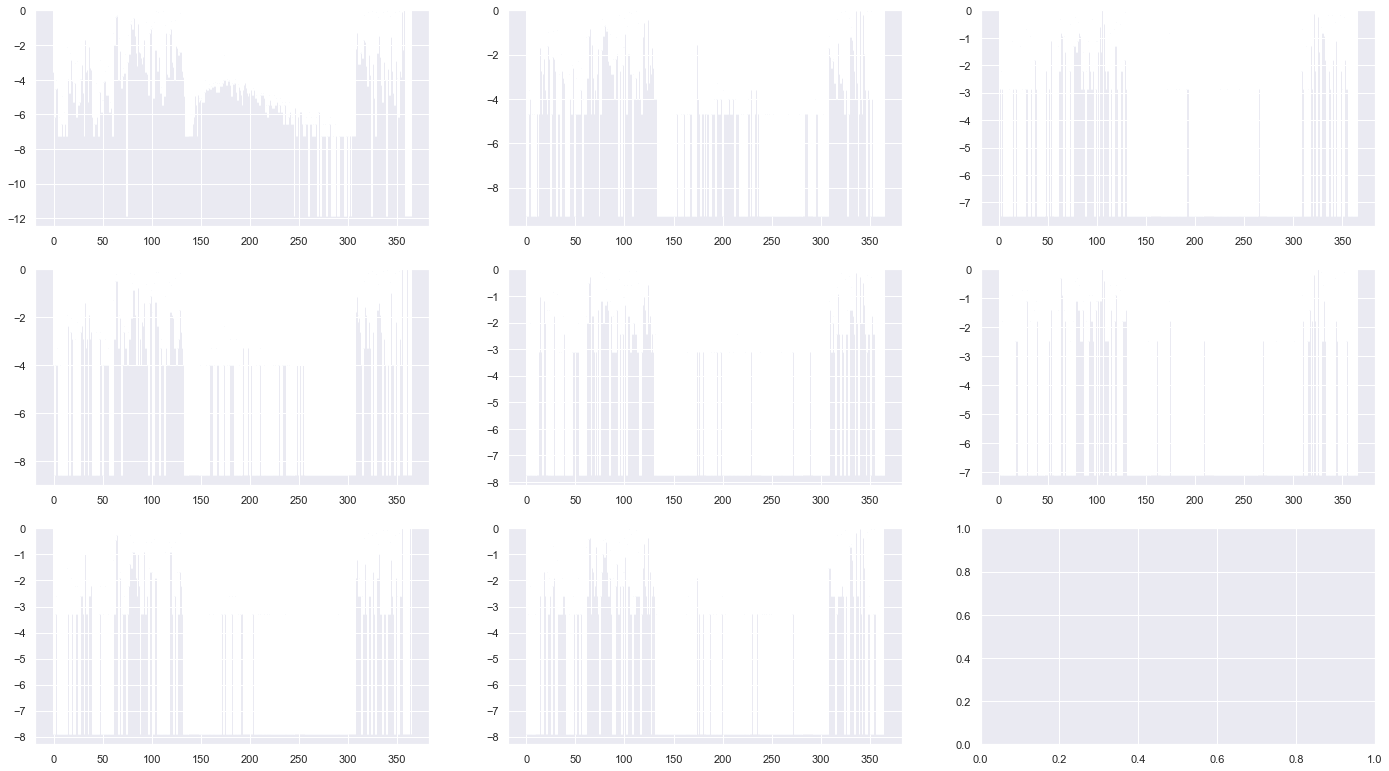

In [128]:
fig_size_scale = 1.5
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16 * fig_size_scale, 9 * fig_size_scale))
for i, ax_flat in enumerate(ax.flatten()):
    if i < clf.feature_log_prob_.shape[0]:
        ax_flat.bar(range(clf.feature_log_prob_.shape[1]), height=clf.feature_log_prob_[i])

In [123]:
np.exp(clf.class_log_prior_).sum()

0.9999999999999998

In [114]:
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7])

In [15]:
cosine_sim_mat

array([[0.        , 0.44921752, 0.52941176, ..., 0.52233485, 0.52069871,
        0.4846118 ],
       [0.44921752, 0.        , 0.36225186, ..., 0.41151011, 0.47201849,
        0.6115507 ],
       [0.52941176, 0.36225186, 0.        , ..., 0.43277264, 0.57708709,
        0.66651352],
       ...,
       [0.52233485, 0.41151011, 0.43277264, ..., 0.        , 0.48487257,
        0.53840691],
       [0.52069871, 0.47201849, 0.57708709, ..., 0.48487257, 0.        ,
        0.53500945],
       [0.4846118 , 0.6115507 , 0.66651352, ..., 0.53840691, 0.53500945,
        0.        ]])

In [96]:
from sklearn.cluster import DBSCAN
clf = DBSCAN(eps=1e-10, min_samples=5, metric="cosine")

In [97]:
clf.fit(df_copy_drop.values)

DBSCAN(eps=1e-10, metric='cosine')

(array([   0.,    0.,    0.,    0.,    0., 1690.,    0.,    0.,    0.,
           0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <a list of 10 Patch objects>)

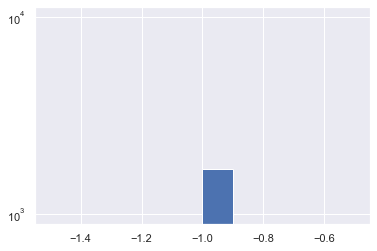

In [98]:
plt.hist(clf.labels_, log=True)

In [99]:
np.unique(clf.labels_)

array([-1])

# DENDOGRAM

In [17]:
dist_matrix = gower.gower_matrix(X)
dist_graph = nx.DiGraph(dist_matrix)
condensed_dist_mat = squareform(dist_matrix)

X = df.iloc[:, 0:df.shape[-1]-12]
#variable_types, binary, continuous, ordinal = detect_variable_type(df, verbose=False)
y = df["LET_IS"]
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)


In [ ]:
Z = linkage(condensed_dist_mat, method="ward")

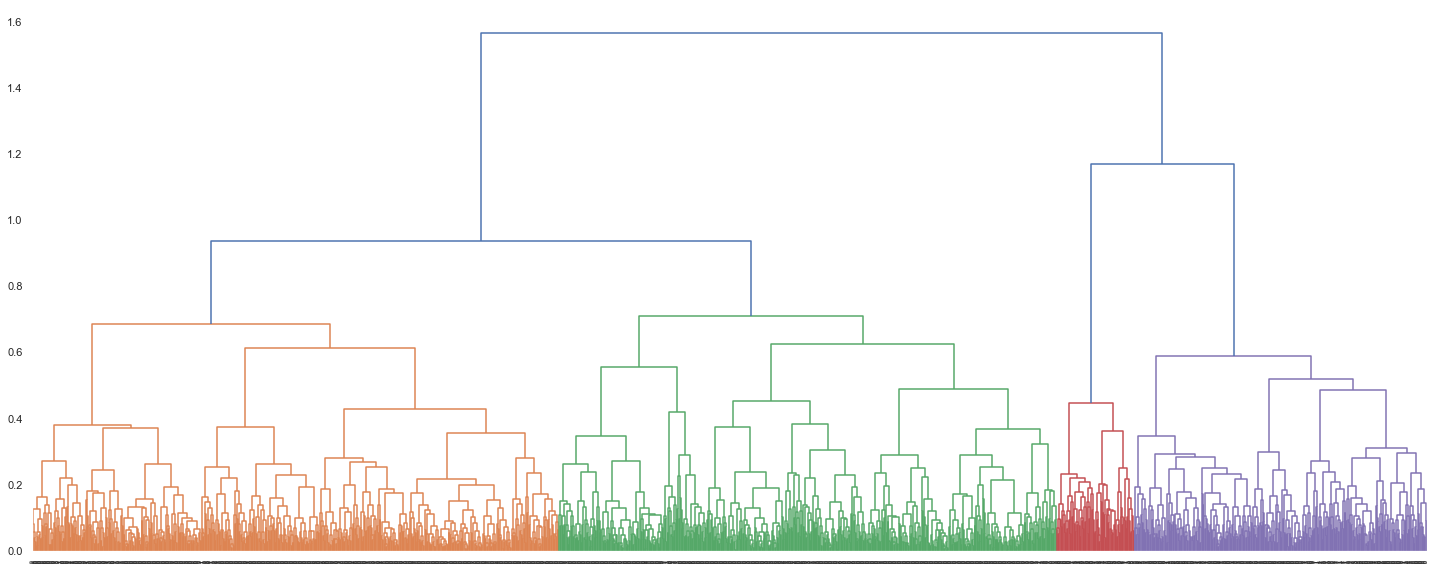

In [18]:
fig, ax = plt.subplots(figsize=(25, 10))
dn = dendrogram(Z, labels=list(y), ax=ax, leaf_rotation=90, color_threshold = 0.8)

In [19]:
leaves = dn["leaves"]
unique_cols = np.unique(dn["color_list"])
clust_dict = defaultdict(list)
for i in range(len(dn["color_list"])):
    clust_dict[dn["color_list"][i]].append(leaves[i])

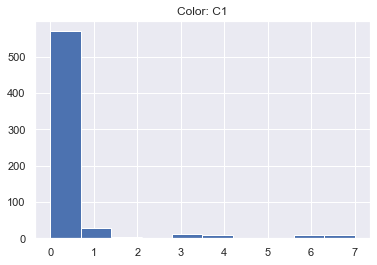

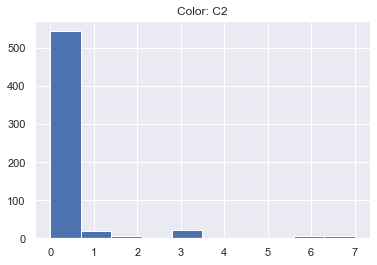

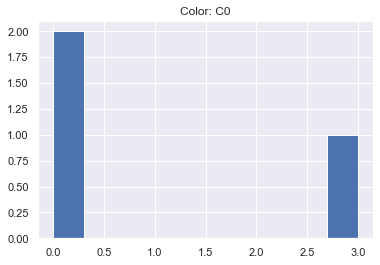

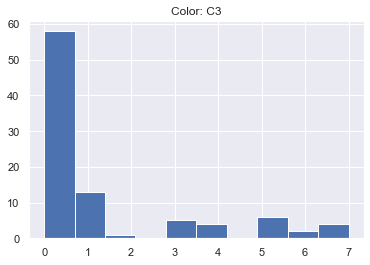

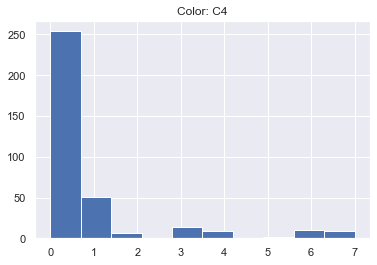

In [20]:
for col, labels in clust_dict.items():
    plt.hist(y[labels])
    plt.title(f"Color: {col}")
    plt.show()

# AGGL. CLUSTERING

In [180]:
clf = AgglomerativeClustering(n_clusters=8, affinity="precomputed", linkage="single")
labels = clf.fit_predict(dist_matrix)

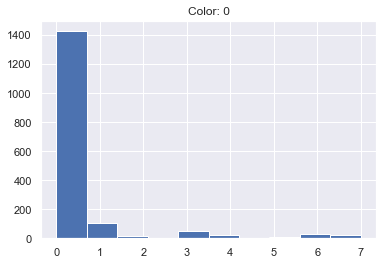

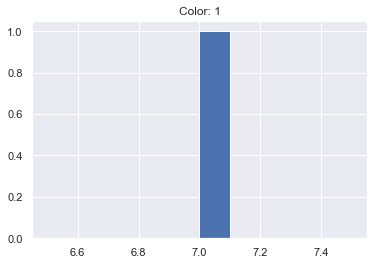

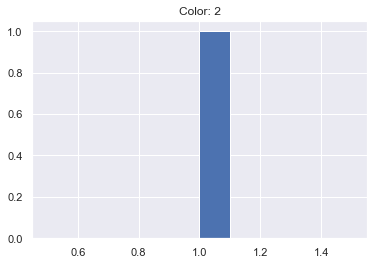

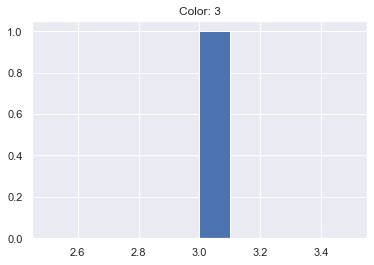

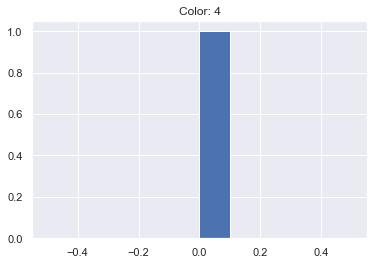

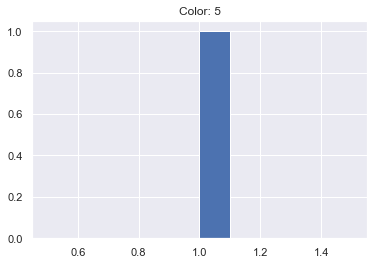

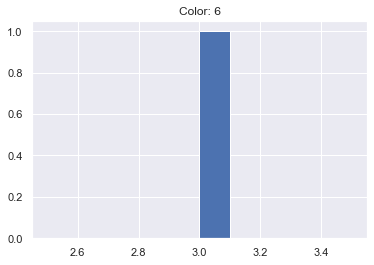

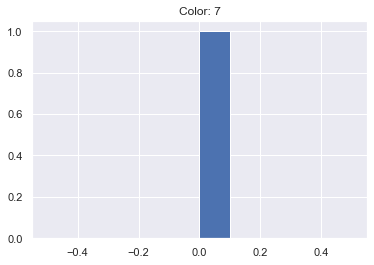

In [181]:
for lab in np.unique(labels):
    label_uniq = labels == lab
    
    plt.hist(y[label_uniq])
    plt.title(f"Color: {lab}")
    plt.show()